In [149]:
# Husa: https://dcc.ligo.org/LIGO-G1901478

In [150]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")


In [151]:
import os
# download HybSur data file: https://git.ligo.org/lscsoft/lalsuite-extra/-/blob/master/data/lalsimulation/NRHybSur3dq8_lal.h5
# set path
os.environ['LAL_DATA_PATH'] = '/Users/sebastian.khan/Downloads/'

In [152]:
import matplotlib.pyplot as plt
plt.figure()
plt.show()
plt.close()
plt.rcParams.update({'font.size':16})
import lalsimulation as lalsim
import phenom
import numpy as np

import waveform_generator
import hybrid_utils

<Figure size 640x480 with 0 Axes>

In [153]:
from scipy.interpolate import InterpolatedUnivariateSpline as IUS

In [154]:
import lmfit

In [155]:
# I don't think this equation is quite correct.
# it doesn't seem to work for the (4,4) mode..
def delta_phi_fn(m):
    z = (-1)*(-1.j)**m
    return np.arctan2(z.imag, z.real)

In [156]:
# modes = [(2,2),(2,1),(3,3),(3,2),(4,4),(4,3)]
modes = [(2,2),(2,1),(3,3),(4,4)]
# modes = [(2,2),(3,2),(4,4)]

# modes = [(2,2),(2,1),(3,3),(4,4),(5,5)]

In [157]:
# nr_hdf5_filename="/Users/sebastian.khan/personal/data/SXS_BBH_0180_Res4.h5" #q=1
nr_hdf5_filename="/Users/sebastian.khan/personal/data/SXS_BBH_0169_Res3.h5" #q=2
# nr_hdf5_filename="/Users/sebastian.khan/personal/data/SXS_BBH_0167_Res5.h5" #q=4
# nr_hdf5_filename="/Users/sebastian.khan/personal/data/SXS_BBH_0107_Res5.h5" #q=5
# nr_hdf5_filename="/Users/sebastian.khan/personal/data/SXS_BBH_0063_Res5.h5" #q=8
# nr_hdf5_filename="/Users/sebastian.khan/personal/data/SXS_BBH_0303_Res3.h5" #q=10


# nr_hdf5_filename="/Users/sebastian.khan/Downloads/MAYA0909.h5"

# nr_hdf5_filename="/Users/sebastian.khan/Downloads/ExtrapStrain_RIT-BBH-0245-n120.h5"
# nr_hdf5_filename="/Users/sebastian.khan/Downloads/ExtrapStrain_RIT-BBH-0337-n120.h5"

# sample spacing in units of M for output NR time series
delta_t=0.1
wf_nr = waveform_generator.get_hdf5_strain(nr_hdf5_filename, modes, delta_t)

print(wf_nr['metadata'])

# should add a test is mass-ratio == 1 and spins are equal then don't include odd-m modes
# try:
#     np.testing.assert_approx_equal(wf_nr['metadata']['q'], 1)
#     modes = [(2,2),(3,2),(4,4)]
# except:
#     pass

f_min=20
# f_min=52
# f_min=13
# f_min=10
# f_min=30

wf_pn = waveform_generator.generate_pn_waveform(
    q=wf_nr['metadata']['q'],
    modes=modes,
    f_min=f_min,
    S1z=wf_nr['metadata']['spin1z']*0,
    S2z=wf_nr['metadata']['spin2z']*0,
    # approximant=lalsim.IMRPhenomTHM
    approximant=lalsim.NRHybSur3dq8
    # approximant=lalsim.TaylorT1
    # approximant=lalsim.SpinTaylorT1
    # approximant=lalsim.SEOBNRv4PHM
)


# fake nr with another model
# wf_nr = waveform_generator.generate_pn_waveform(
#     q=wf_nr['metadata']['q'],
#     modes=modes,
#     # f_min=f_min+4,
#     f_min=20,
#     S1z=wf_nr['metadata']['spin1z'],
#     S2z=wf_nr['metadata']['spin2z'],
#     approximant=lalsim.IMRPhenomTHM
#     # approximant=lalsim.NRHybSur3dq8
#     # approximant=lalsim.SpinTaylorT4
# )




{'q': 1.9999733299310347, 'filename': '/Users/sebastian.khan/personal/data/SXS_BBH_0169_Res3.h5', 'M': 0.9999989852, 'spin1z': 7.25872862782e-08, 'spin2z': -4.69907717671e-07}


In [158]:
###
# from https://git.ligo.org/hector.estelles/waveform-conventions/-/tree/master/

def UIBMod(xarray, angle):

	""" It is simply a custom modulo function """

	ret = np.zeros(len(xarray))
	for i, x in enumerate(xarray):
	    mod = x%angle
    
	    if mod>angle/2:
	        ret[i] = mod - angle
	    else:
	        ret[i] = mod
	return ret


In [159]:
# psi0 = -np.pi
# # psi0 = np.pi
# # psi0 = 0

# hlms = wf_pn['hlm'].copy()
# for mode in hlms.keys():
#     hlms[mode] = hlms[mode] * np.exp(1.j*psi0)
# wf_pn['hlm'] = hlms.copy()

wf_pn = hybrid_utils.compute_phase(wf_pn)




for i, mode in enumerate(modes):
    ell = mode[0]
    m = mode[1]
    zz = 2*wf_pn['phase'][mode] - m*wf_pn['phase'][2,2]
    zz = UIBMod(zz, 2*np.pi)
    plt.plot(wf_pn['t'], zz, c=f"C{i}", label=mode)
    # expected_value = psi0 * (2 - m)
    # plt.axhline(expected_value, c=f"C{i}", ls='--')
plt.ylim(-10,10)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

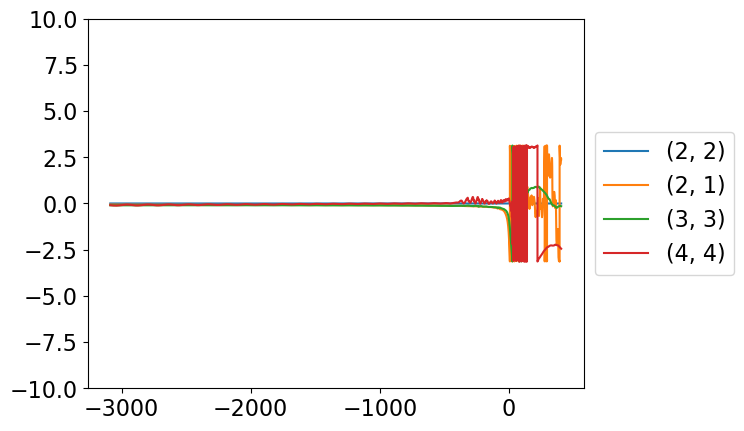

In [160]:
# psi0 = -np.pi
psi0 = np.pi
# psi0 = 0


hlms = wf_nr['hlm'].copy()
for mode in hlms.keys():
    hlms[mode] = hlms[mode] * np.exp(1.j*psi0)
wf_nr['hlm'] = hlms.copy()


wf_nr = hybrid_utils.compute_phase(wf_nr)


for i, mode in enumerate(modes):
    ell = mode[0]
    m = mode[1]
    zz = 2*wf_nr['phase'][mode] - m*wf_nr['phase'][2,2]
    zz = UIBMod(zz, 2*np.pi)
    plt.plot(wf_nr['t'], zz, c=f"C{i}", label=mode)
    # expected_value = psi0 * (2 - m)
    # plt.axhline(expected_value, c=f"C{i}", ls='--')
plt.ylim(-10,10)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# leading order phase shifts

In [161]:
# wf_pn = wf_nr

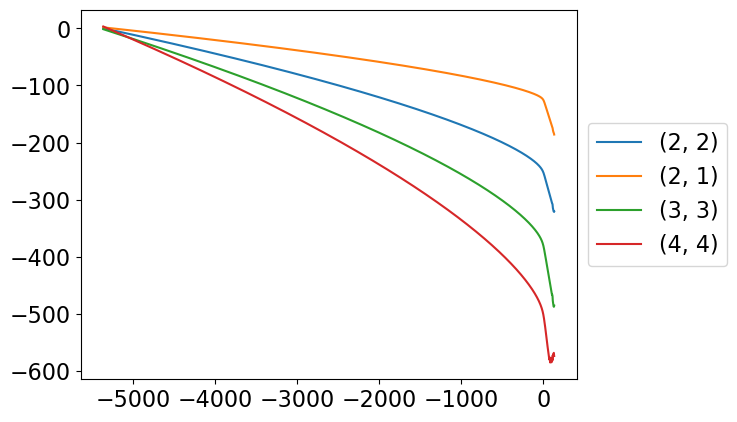

In [162]:
for i, mode in enumerate(modes):
    ell = mode[0]
    m = mode[1]
    plt.plot(wf_pn['t'], wf_pn['phase'][mode], c=f"C{i}", label=mode)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [164]:
# http://arxiv.org/abs/2012.11923 equations 13a - 13f

In [165]:
phase_shift = {
    (2,2):0,
    (2,1):np.pi/2,
    (3,3):-np.pi/2,
    (4,4):np.pi,
}

In [168]:
delta_phi_fn(2)

-0.0

In [169]:
delta_phi_fn(1)

1.5707963267948966

In [170]:
delta_phi_fn(3)

-1.5707963267948966

In [171]:
delta_phi_fn(4)

3.141592653589793

(-10.0, 10.0)

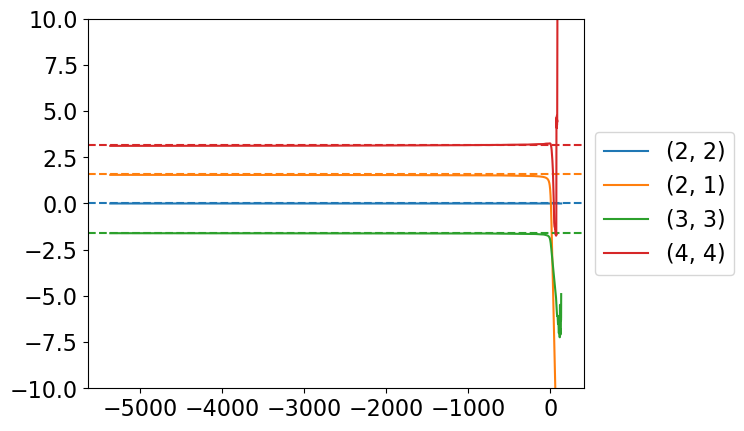

In [167]:
for i, mode in enumerate(modes):
    ell = mode[0]
    m = mode[1]
    zz = wf_pn['phase'][mode] - m*wf_pn['phase'][2,2]/2
    plt.plot(wf_pn['t'], zz, c=f"C{i}", label=mode)
    plt.axhline(phase_shift[mode], c=f'C{i}', ls='--')
    # plt.axhline(delta_phi_fn(m), c=f'C{i}', ls='--')
    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.xlim(-5000, -4000)
plt.ylim(-10,10)

(-10.0, 10.0)

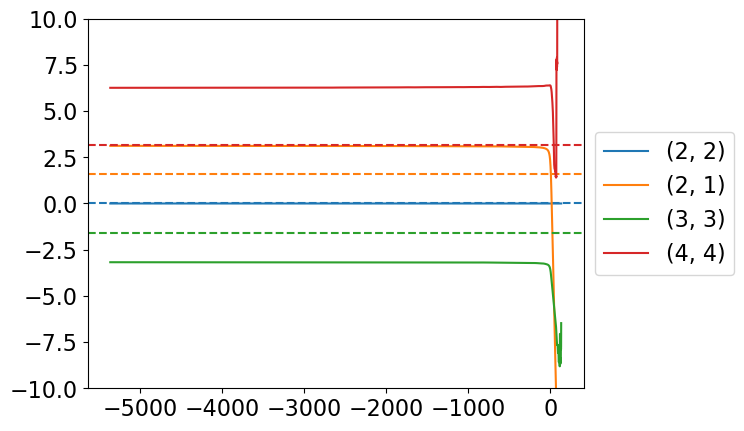

In [166]:
for i, mode in enumerate(modes):
    ell = mode[0]
    m = mode[1]
    zz = wf_pn['phase'][mode] - (m*wf_pn['phase'][2,2]/2 - phase_shift[mode])
    plt.plot(wf_pn['t'], zz, c=f"C{i}", label=mode)
    plt.axhline(phase_shift[mode], c=f'C{i}', ls='--')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim(-10,10)